In [1]:
# Load package
import numpy as np; from scipy import stats; import matplotlib.pyplot as plt; import pymc as pm;import arviz as az; 
import math; import pandas as pd
from scipy.optimize import minimize
from scipy import special
import pytensor.tensor as pt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def generate_Corr_identity(p):

    Sigma = np.zeros((p-1, p-1))
    np.fill_diagonal(Sigma, 1)
    return Sigma

def generate_data(n, p, sigma_sqr, beta, nu, corr):

    beta = beta.reshape((p, 1))
    x_i = np.random.normal(0, 1, (n, p - 1))
    x_i_correlated = x_i @ corr
    ones = np.ones((n, 1))
    x_i_full =  np.concatenate((ones, x_i_correlated), axis=1)
    XB = x_i_full @ beta
    E = stats.t.rvs(df = nu, loc=0, scale= np.sqrt(sigma_sqr), size=(n, 1))
    Y = XB + E
    return Y, x_i_full,x_i

def calculate_y_axix(nu_origin, nu_est):
    n = len(nu_est)
    if n == 0:
        return -1
    else:
        nu_origin_vec = nu_origin * np.ones((n, 1))
        mse = np.sum((nu_est - nu_origin_vec)**2) / n
        result = np.sqrt(mse)/nu_origin
        return result

# Task 1: Optimize over all three params directly on full likelihood or full joint

In [13]:
# Generate Data
p = 5 #number of betas
beta = np.array([2, 1, 0.3, 0.9,1])
n = 1000
nu_origin = 5
sigma_sqr = 1.5
corr = generate_Corr_identity(p)  
y, X, x_without_1 = generate_data(n, p, sigma_sqr, beta, nu_origin, corr)

In [5]:
# full likelihood
def negative_log_likelihood(params):
    betas, sigma, nu = params[:-2], params[-2], params[-1]
    p = X.shape[1]
    B = np.reshape(betas, (p, 1))
    XB = X @ B
    n = X.shape[0]
    XB = XB.reshape((n, 1))
    
    # loglikelihood
    equation = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))
    return -equation

In [6]:
def optimizer_all_three_params(eqt):
    p = X.shape[1]
    bounds = [(None, None)] * p +[(0, np.inf)]*2
    initial_guess = np.random.normal(0, 1, size = (p+2))
    initial_guess[p] = np.abs(initial_guess[p])
    result = minimize(eqt, initial_guess, method='Nelder-Mead',bounds= bounds, options={'return_all':True})
    return result

#[result.x,result.success,result.nit,result.allvecs]

In [14]:
# optimize all three params at the same time
optimizer_all_three_params(negative_log_likelihood).success

True

In [15]:
# Jeffrey's prior
def logJeff(x):
    return np.log((x/(x+3))**(1/2)*(special.polygamma(1,x/2) - special.polygamma(1, (x+1)/2) - 2*(x+3)/(x*(x+1)**2))**(1/2))

# full joint
def negative_joint(params):
    nu = params[-1]
    return -logJeff(nu) + negative_log_likelihood(params)

In [16]:
# optimize all three params at the same time
optimizer_all_three_params(negative_joint).success

True

# Task 2: Try least square estimator as initial guess 

In [23]:
# Generate Data
p = 5 #number of betas
beta = np.array([2, 1, 0.3, 0.9,1])
n = 1000
nu_origin = 5
sigma_sqr = 1.5
corr = generate_Corr_identity(p)  
y, X, x_without_1 = generate_data(n, p, sigma_sqr, beta, nu_origin, corr)

In [24]:
def initial_guess_from_lin_reg(x_without_1, y,nu_origin):
    initial_guess = []
    
    model = LinearRegression().fit(x_without_1, y)
    # intercept 
    initial_guess.append(float(model.intercept_))
    # coeff
    for coeff in model.coef_[0]:
        initial_guess.append(coeff)
    # sigma_sq    
    y_pred = model.predict(x_without_1)
    residual_sq = (((y - y_pred)**2).sum())/(n-2)
    initial_guess.append(residual_sq)
    
    # nu
    initial_guess.append(nu_origin) # use true nu for initial guess
    return initial_guess

In [25]:
initial_guess = initial_guess_from_lin_reg(x_without_1, y,nu_origin)

In [26]:
def optimizer_all_three_params_least_sq(eqt, initial_guess):
    p = X.shape[1]
    bounds = [(None, None)] * p +[(0, np.inf)]*2
    result = minimize(eqt, initial_guess, method='Nelder-Mead',bounds = bounds, options={'return_all':True})
    return result

In [29]:
result = optimizer_all_three_params_least_sq(negative_log_likelihood, initial_guess)

In [32]:
result.x

array([1.97080113, 1.09361841, 0.31612429, 0.91410687, 0.9750982 ,
       1.1874797 , 3.51146523])

In [264]:
optimizer_all_three_params_least_sq(negative_joint, initial_guess).success

True

# Task 3: MSE plot with new optimizer

In [20]:
def fix_x_generate_data(n, p, sigma_sqr, beta, nu, corr,X):

    beta = beta.reshape((p, 1))
    XB = X @ beta
    E = stats.t.rvs(df = nu, loc=0, scale= np.sqrt(sigma_sqr), size=(n, 1))
    Y = XB + E
    return Y

In [21]:
# Fix number of observations
n = 100

result_value_mse_profile = []
result_value_mse_adj_profile =[] 
result_value_mse_profile_joint =[]
nu_list = []

p = 5
beta = np.array([2, 1, 0.3, 0.9, 1])
sigma_sqr = 1.5
corr = generate_Corr_identity(p)

x_without_1 = np.random.normal(0, 1, (n, p - 1))
x_i_correlated = x_without_1 @ corr
ones = np.ones((n, 1))
X =  np.concatenate((ones, x_i_correlated), axis=1)


for nu_origin in range(1,26): # loop true nu 
    nu_list.append(nu_origin)
    mle_profile =[]
    map_profile = []

    for j in range(50): # number of simulations 
        y = fix_x_generate_data(n, p, sigma_sqr, beta, nu_origin, corr, X) ## Generate data
        initial_guess = initial_guess_from_lin_reg(x_without_1, y,nu_origin)
        
        # profile likelihood MLE
        profile_result = optimizer_all_three_params_least_sq(negative_log_likelihood, initial_guess)
        if profile_result.success == True:
            mle_profile.append(profile_result.x[-1])
            print(profile_result.nit)

        # profile joint MAP
        profile_joint_result = optimizer_all_three_params_least_sq(negative_joint, initial_guess)
        if profile_joint_result.success == True:
            map_profile.append(profile_joint_result.x[-1])
            print(profile_joint_result.nit)
        
    # record averaged MSE 
    value_mse_profile = calculate_y_axix(nu_origin, mle_profile)
    result_value_mse_profile.append(value_mse_profile) 
    
    value_mse_profile_joint = calculate_y_axix(nu_origin, map_profile)
    result_value_mse_profile_joint.append(value_mse_profile_joint)
    
    print('profile MLE mse: ' + str(len(mle_profile)) + ' converged')
    print('profile MAP mse: ' + str(len(map_profile)) + ' converged')
    print(str(nu_origin) + ' true nu done')

df = pd.DataFrame({'nu': nu_list,
                    'MSE profile likellihood': result_value_mse_profile,
                   'MSE profile joint MAP':result_value_mse_profile_joint
                   
                        })

840
692
881
467
920
769
874
485
705
893
761
782
793
902
684
747
812
804
773
848
794
403
396
856
812
835
878
864
840
535
866
462
419
856
339
780
836
877
867
666
828
874
751
890
822
900
810
743
788
448
864
859
861
908
798
profile MLE mse: 26 converged
profile MAP mse: 29 converged
1 true nu done
546
560
679
611
847
777
771
790
831
657
677
712
676
806
848
758
490
909
564
571
612
672
778
799
705
824
538
550
724
595
775
782
689
772
723
664
862
629
693
746
745
674
657
920
747
769
685
608
640
680
696
669
825
836
501
694
677
822
915
846
534
903
728
679
710
672
688
572
682
764
743
663
849
650
823
584
561
734
648
680
851
622
626
644
527
803
profile MLE mse: 44 converged
profile MAP mse: 42 converged
2 true nu done
650
554
641
781
479
529
479
416
566
527
677
548
644
628
627
660
636
745
828
596
660
445
554
804
492
586
649
654
404
447
685
624
442
632
635
741
659
817
662
592
707
610
775
585
606
735
596
616
650
710
849
725
770
776
679
616
677
661
595
703
460
725
703
638
605
719
575
520
640
572
509
62

585
432
553
464
profile MLE mse: 29 converged
profile MAP mse: 50 converged
20 true nu done
546
557
501
463
595
435
448
500
585
476
303
649
420
339
640
501
578
727
844
673
526
586
790
437
482
387
392
576
630
543
565
480
685
488
627
643
572
538
529
497
497
513
421
518
532
584
436
455
565
535
578
359
519
549
707
556
754
645
423
553
548
602
583
506
462
600
630
558
528
572
537
469
411
456
531
639
560
556
profile MLE mse: 28 converged
profile MAP mse: 50 converged
21 true nu done
536
585
456
430
463
516
639
823
569
583
559
533
441
488
507
561
598
749
543
498
474
438
560
581
497
443
564
487
369
657
450
527
517
385
703
525
424
487
570
555
487
736
729
417
465
359
594
535
308
557
681
520
767
469
508
503
557
494
519
442
561
521
412
482
456
668
547
444
414
582
715
548
profile MLE mse: 22 converged
profile MAP mse: 50 converged
22 true nu done
759
633
774
492
531
463
514
543
587
462
545
448
521
769
465
637
587
511
541
563
589
525
456
768
522
468
482
428
386
391
467
583
494
683
603
470
526
550
475


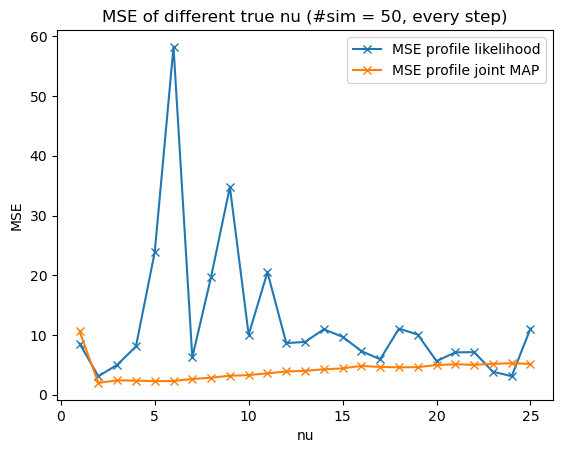

In [22]:
# Plot MSE vs nu 

# Plotting
plt.plot(df['nu'], df['MSE profile likellihood'], label='MSE profile likelihood', marker= "x")
plt.plot(df['nu'], df['MSE profile joint MAP'], label='MSE profile joint MAP', marker="x")

# Adding labels and legend
plt.xlabel('nu')
plt.ylabel('MSE')
plt.title('MSE of different true nu (#sim = 50, every step)') 
plt.legend()
# Showing the plot
plt.show()

# Task 4: High dim

In [11]:
# Fix number of observations
n = 30
nu_origin = 5 
first_5_betas = np.array([2, 1, 0.3, 0.9, 1])
sigma_sqr = 1.5

result_value_mle_profile = []
result_value_map_profile = []
dim_list = []


# Generate data for different dim       
for p in range(5, 30): ## loop for high dim predictors 
    dim_list.append(p)
    
    beta = first_5_betas
    corr = generate_Corr_identity(p)
    for extra_betas in range(p-5):
        beta = np.append(beta,0) 
    x_without_1 = np.random.normal(0, 1, (n, p - 1))
    x_i_correlated = x_without_1 @ corr
    ones = np.ones((n, 1))
    X =  np.concatenate((ones, x_i_correlated), axis=1)
    
    mle_profile = []
    map_profile =[]
        
    for j in range(50): # number of simulations 
        y = fix_x_generate_data(n, p, sigma_sqr, beta, nu_origin, corr, X) ## Generate data
        initial_guess = initial_guess_from_lin_reg(x_without_1, y,nu_origin)
        
        # profile likelihood MLE
        profile_result = optimizer_all_three_params_least_sq(negative_log_likelihood, initial_guess)
        if profile_result.success == True:
            mle_profile.append(profile_result.x[-1])
            print(profile_result.x)

        # profile joint MAP
        profile_joint_result = optimizer_all_three_params_least_sq(negative_joint, initial_guess)
        if profile_joint_result.success == True:
            map_profile.append(profile_joint_result.x[-1])
            print(profile_joint_result.x)
        

    # record averaged MSE 
    value_mse_mle_profile = calculate_y_axix(nu_origin, mle_profile)
    result_value_mle_profile.append(value_mse_mle_profile) 
    
    value_mse_map_profile = calculate_y_axix(nu_origin, map_profile)
    result_value_map_profile.append(value_mse_map_profile)
    
    print('profile MLE mse: ' + str(len(mle_profile)) + ' converged')
    print('profile MAP mse: ' + str(len(map_profile)) + ' converged')
    print(str(p) + ' dimension done')

df = pd.DataFrame({'dim': dim_list,
                    'MSE profile MLE': result_value_mle_profile,
                   'MSE profile joint MAP': result_value_map_profile})

[1.83684313 1.1984163  0.61664389 0.75916256 0.70447533 0.9677065
 2.36724556]
[1.84156725 1.24292267 0.59138044 0.80982055 0.67238907 0.87829888
 1.74665183]
[ 2.08338557  1.23759753  0.51370646  1.52096467  0.64485632  1.38678133
 34.96124459]
[2.16368945 1.1278182  0.39827137 1.61547855 0.7499039  1.08337177
 2.92183644]
[ 2.39436666  1.4367761  -0.07895307  1.16993812  0.93213643  0.93420288
  3.18976826]
[2.23335582 0.54550672 0.37109129 0.1800935  1.11715543 0.37057417
 0.78595858]
[1.75250932 1.15586484 0.62643665 1.0626005  0.49922091 0.90895949
 2.52005423]
[1.72975205 1.11962455 0.16128821 1.44952614 1.13661224 1.02722288
 2.51683326]
[1.76933748 0.88537934 0.1548593  0.64623412 1.18328935 0.71188035
 1.70981182]
[ 1.62561467  1.14261119 -0.25623996  1.50045713  0.75867714  1.07831843
  3.221682  ]
[1.90572358 1.60811584 0.42258085 0.15494403 0.85300748 0.86999667
 2.97806284]
[1.89852474 1.6220268  0.4099307  0.16377674 0.85845694 0.81450316
 2.17612754]
[ 2.27200339  0.9238

[ 2.25895567  0.43531125 -0.55797289  0.48421727  1.16281434  0.15123775
  1.12949691  3.80736251]
[ 2.48030036  0.61339312 -0.30633488  0.69041981  0.74744283 -0.38878835
  0.92715689  1.34738633]
[ 2.46877877  0.62998344 -0.08792225  0.70981077  0.64741647  0.0684975
  0.76702527  3.67207438]
[1.80967314 1.35063023 0.59982456 1.36310231 0.78941337 0.14956052
 1.01543582 3.47401803]
[1.80211956 1.45019572 0.66322492 1.35493373 0.82581072 0.09232918
 0.91975361 2.25205642]
[2.25490265 0.76644728 0.05785334 0.95339207 0.95957929 0.03945673
 0.88293434 2.42859604]
[1.99517039 0.70557796 0.44594416 1.11334002 1.0760897  0.17998511
 1.01284004 4.45490085]
[1.84299667 0.4507178  0.61042329 1.22577925 0.97924843 0.18627336
 0.53577777 1.14086408]
[1.99619793 0.87545378 0.45454766 1.42457886 1.40931715 0.26618519
 0.61242527 1.3460635 ]
[2.01274117 0.87269526 0.46322847 1.49165264 1.43942902 0.30159959
 0.54089342 1.09196764]
[ 2.30725109  1.15633306  0.32542538  1.1362926   0.83790148 -0.114

[ 2.21148041  1.31191956  0.9280578   1.53168386  1.1622771   0.3615874
 -0.3293713  -0.39128297  0.82569589  4.12232289]
[ 1.46615686  1.16884461  0.02146878  0.67956046  1.28010841 -0.81836173
 -0.27601641  0.1474661   0.64202853  2.42976164]
[ 2.11556441  0.66254984  0.07416374  0.7817498   0.73132916 -0.30157606
  0.40659373  0.0348454   0.52558717  1.72322661]
[ 2.09922163  1.00691887  0.15240965  0.65329365  1.03916126  0.11216041
  0.17104407 -0.22169889  0.89509871  1.91190428]
profile MLE mse: 2 converged
profile MAP mse: 6 converged
8 dimension done
[ 1.52374134  1.09418448  0.27418267  0.88951478  1.0633659  -0.15089139
 -0.04135885 -0.55247865 -0.0693541   0.71690587  1.7252978 ]
[ 2.15286839  0.90612441  0.24910375  1.29121969  0.93424103  0.19156348
  0.05632507 -0.21667037 -0.51619732  0.73984473  2.22973052]
profile MLE mse: 1 converged
profile MAP mse: 1 converged
9 dimension done
[ 1.84785914e+00  8.94007424e-01  3.77142533e-01  3.88751583e-01
  4.22988713e-01 -6.7655

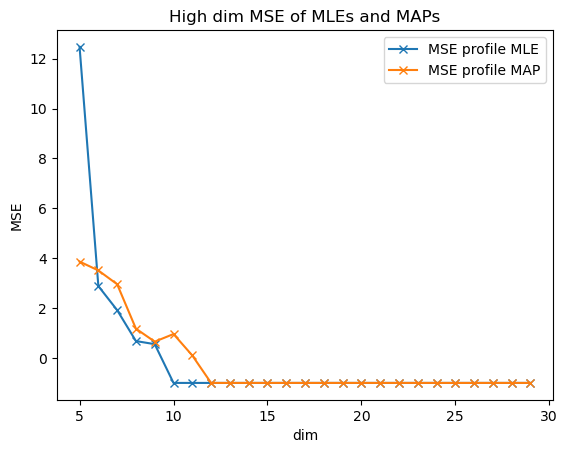

In [12]:
# Plot profile MAP(grid search) vs nu 

# Plotting
plt.plot(df['dim'], df['MSE profile MLE'], label='MSE profile MLE', marker="x")
plt.plot(df['dim'], df['MSE profile joint MAP'], label='MSE profile MAP', marker="x")
# Adding labels and legend
plt.xlabel('dim')
plt.ylabel('MSE')
plt.title('High dim MSE of MLEs and MAPs') 
plt.legend()
# Showing the plot
plt.show()

# Task 5: Bootstrapping from real dataset

In [67]:
# Sample size
n = 35

# Load data
bond_data = pd.read_csv('U.S. Treasury bond prices (Sheather).csv')

mle_converged = 0
map_converged = 0
nu_guess = np.random.normal(2, 1)

for j in range(50):
    # Bootstrapping
    x_without_1 = []
    y = []
    i_list = np.random.choice(range(n),size=n, replace=True)
    for i in i_list:
        x_without_1.append([bond_data['CouponRate'][i]])
        y.append([bond_data['BidPrice'][i]])
    ones = np.ones((n, 1))
    X =  np.concatenate((ones, x_without_1), axis=1)
    # initial_guess for bootstrapped sample
    initial_guess = initial_guess_from_lin_reg(x_without_1, y , nu_guess)

    # profile likelihood MLE
    profile_result = optimizer_all_three_params_least_sq(negative_log_likelihood, initial_guess)
    if profile_result.success == True:
        mle_converged += 1
        print(profile_result.nit)

    # profile joint MAP
    profile_joint_result = optimizer_all_three_params_least_sq(negative_joint, initial_guess)
    if profile_joint_result.success == True:
        map_converged +=1
        print(profile_joint_result.nit)

print('number of mle converged: ' + str(mle_converged))
print('number of map converged: ' + str(map_converged))

228
206
191
217
218
208
174
189
214
213
193
223
232
195
204
200
185
207
243
173
141
224
261
171
213
194
183
182
385
154
235
202
206
223
198
267
317
230
225
159
224
210
203
170
209
204
209
192
227
233
223
260
256
193
254
246
237
217
271
174
165
221
192
217
209
208
225
221
200
142
206
207
308
201
221
220
276
220
235
230
161
151
182
193
195
197
210
218
146
152
193
192
number of mle converged: 44
number of map converged: 48
